In [1]:
import pandas as pd
import numpy as np

# get data metafeatures
metafeatures = pd.read_csv('../metafeatures/data_metafeatures.csv',sep=',',index_col=0)
print('loaded ', metafeatures.shape[1]-1, ' metafeatures for ', metafeatures.shape[0], ' datasets')
# get ML results
data = pd.read_csv('sklearn-benchmark5-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
print('loaded ',data['dataset'].unique().shape[0],'datasets and ', data['classifier'].unique().shape[0],'classifiers')
# subset data to classifiers used in PennAI
pennai_classifiers = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 
                      'KNeighborsClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
mask = np.array([c in pennai_classifiers for c in data['classifier'].values])
data = data.loc[mask,:]
print('classifiers:',data['classifier'].unique())

loaded  44  metafeatures for  166  datasets
loaded  166 datasets and  14 classifiers
classifiers: ['RandomForestClassifier' 'SVC' 'KNeighborsClassifier'
 'GradientBoostingClassifier' 'LogisticRegression' 'DecisionTreeClassifier']


# can we predict which learner will be best on a dataset from dataset properties?

100%|██████████| 166/166 [00:00<00:00, 1147.42it/s]
/home/bill/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


methods: ['RandomForestClassifier' 'SVC' 'KNeighborsClassifier'
 'GradientBoostingClassifier' 'LogisticRegression' 'DecisionTreeClassifier']
metafeatures[dataset].shape: (166,)
9  features dropped due to missing values
X shape: (166, 35)
y shape: (166,)
fitting model...
confusion matrix:
Confusion matrix, without normalization
[[ 0  4  0  0  1  0]
 [ 2 66  0  1  5  8]
 [ 0  4  0  0  0  2]
 [ 0  2  0  2  0  4]
 [ 0 17  0  0 11  1]
 [ 0 18  1  1  1 15]]
Normalized confusion matrix
[[ 0.    0.8   0.    0.    0.2   0.  ]
 [ 0.02  0.8   0.    0.01  0.06  0.1 ]
 [ 0.    0.67  0.    0.    0.    0.33]
 [ 0.    0.25  0.    0.25  0.    0.5 ]
 [ 0.    0.59  0.    0.    0.38  0.03]
 [ 0.    0.5   0.03  0.03  0.03  0.42]]


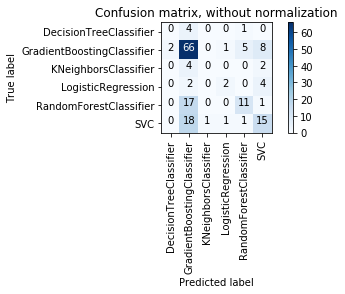

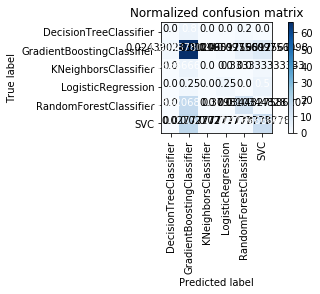

In [26]:
# get best classifier for each dataset
from tqdm import tqdm 
best_method = dict()
for i,(dataset, group_data) in enumerate(tqdm(data.groupby('dataset'))):
    best_method[dataset] = group_data['classifier'][np.argmax(group_data['accuracy'])]

# print(best_method)

# make new dataset combining metafeatures and best methods
y = np.empty(metafeatures.shape[0])
methods = data['classifier'].unique()
print('methods:',methods)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# le.fit(methods)

print('metafeatures[''dataset''].shape:',metafeatures['dataset'].shape)
y_str = [best_method[ds] for ds in metafeatures['dataset'].values]

y = le.fit_transform(y_str)

metaf = metafeatures.dropna(axis=1,how='all')
metaf.fillna(value=0,axis=1,inplace=True)
print(metafeatures.shape[1]-metaf.shape[1],' features dropped due to missing values')
# print(metaf[:10])
from sklearn.preprocessing import StandardScaler, Normalizer

X = Normalizer().fit_transform(metaf.drop('dataset',axis=1).values)
print('X shape:',X.shape)
print('y shape:',y.shape)

# set up ML 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, LeaveOneOut, cross_val_predict
from sklearn.metrics import confusion_matrix

# dtc = DecisionTreeClassifier()
dtc = RandomForestClassifier(n_estimators=1000)
# dtc = KNeighborsClassifier(n_neighbors=1)
# dtc.fit(X_t,y_t)
cv = StratifiedShuffleSplit(n_splits=30,test_size=0.1)
print('fitting model...')
# print('mean CV score:',np.mean(cross_val_score(dtc,X,y,cv=LeaveOneOut())))
# print('mean CV score:',np.mean(cross_val_score(dtc,X,y,cv=cv)))

print('confusion matrix:')
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y,cross_val_predict(dtc,X,y,cv=LeaveOneOut()))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# can we predict the best score achievable on a dataset from dataset properties?

In [14]:
# get best classifier for each dataset
from tqdm import tqdm 
best_score = dict()


# print(best_method)

# make new dataset combining metafeatures and best methods
y = np.empty(metafeatures.shape[0])
for i,(dataset, group_data) in enumerate(tqdm(data.groupby('dataset'))):
   y[i] = group_data['bal_accuracy'].max()

print('metafeatures[''dataset''].shape:',metafeatures['dataset'].shape)


metaf = metafeatures.dropna(axis=1,how='all')
metaf.fillna(value=0,axis=1,inplace=True)

print(metafeatures.shape[1]-metaf.shape[1],' features dropped due to missing values')
# print(metaf[:10])

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(metaf.drop('dataset',axis=1).values)
print('X shape:',X.shape)
print('y shape:',y.shape)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import cross_val_score

# X_t,X_v,y_t,y_v = train_test_split(X,y)

# est = DecisionTreeClassifier()
est = RandomForestRegressor(n_estimators=100)
# est = LassoLarsCV()
# dtc.fit(X_t,y_t)
print('fitting model...')
print('mean CV score:',np.mean(cross_val_score(est,X,y,cv=5)))

100%|██████████| 166/166 [00:00<00:00, 366.18it/s]
/home/bill/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/bill/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=3.126e-04, previous alpha=4.224e-05, with an active set of 23 regressors.
  ConvergenceWarning)
/home/bill/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=8.702e-05, previous alpha=4.364e-05,

metafeatures[dataset].shape: (166,)
9  features dropped due to missing values
X shape: (166, 35)
y shape: (166,)
fitting model...
mean CV score: -0.194007105864


/home/bill/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=6.347e-04, previous alpha=2.807e-05, with an active set of 31 regressors.
  ConvergenceWarning)
/home/bill/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=2.737e-04, previous alpha=4.824e-06, with an active set of 25 regressors.
  ConvergenceWarning)
/home/bill/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=6.191e-05, previous alpha=1.402e-05, with an active set of 23 re